In [1]:
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd

import pandas_datareader as pdr
from pandas_datareader import data as wb
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.family' : 'sans'})
sm, med, lg = 10, 15, 20
plt.rc('font', size = sm)         # controls default text sizes
plt.rc('axes', titlesize = med)   # fontsize of the axes title
plt.rc('axes', labelsize = med)   # fontsize of the x & y labels
plt.rc('xtick', labelsize = sm)   # fontsize of the tick labels
plt.rc('ytick', labelsize = sm)   # fontsize of the tick labels
plt.rc('legend', fontsize = sm)   # legend fontsize
plt.rc('figure', titlesize = lg)  # fontsize of the figure title
plt.rc('axes', linewidth=2)       # linewidth of plot lines


import seaborn as sns
sns.set()

from scipy.optimize import minimize

import itertools
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from mpl_finance import candlestick_ohlc
from tqdm import tqdm_notebook
from pylab import rcParams


import yfinance as yf
from yahoofinancials import YahooFinancials
from urllib.request import urlopen
import requests


import locale, sys 
from datetime import date, datetime, timedelta
import time, csv, json, os, math

from IPython.display import IFrame
# ![img](images/paintcarelogo.png)

import warnings
warnings.filterwarnings('ignore')


print('\n          * * * NO ISSUES - ALL IMPORTS LOADED * * * \n')


          * * * NO ISSUES - ALL IMPORTS LOADED * * * 



# Standard Inputs:

In [2]:
start = datetime(2018, 1, 2)
end = datetime.now()

ticker = 'TSLA'
# ticker = input('Ticker: ')
tickers = [ticker, '^GSPC', '^IXIC', '^DJI']

# Simple Time Series Model:

In [7]:
sns.set_style('darkgrid')

stock = pdr.get_data_yahoo(ticker, start=start,end=end)
stock.to_csv('data/simpleTS.csv')
stock = pd.read_csv('data/simpleTS.csv')

STATIONARY DATA


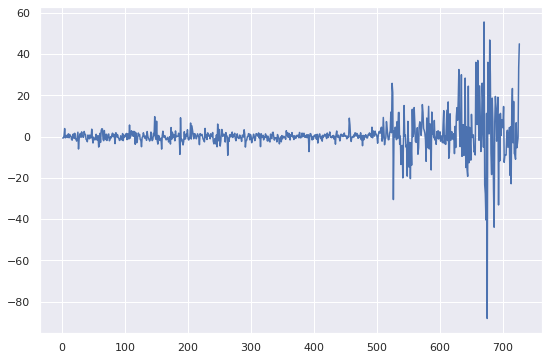

In [12]:
stock['First Difference'] = stock['Close'] - stock['Close'].shift()
stock['First Difference'].plot(figsize=(9,6))
print('STATIONARY DATA')

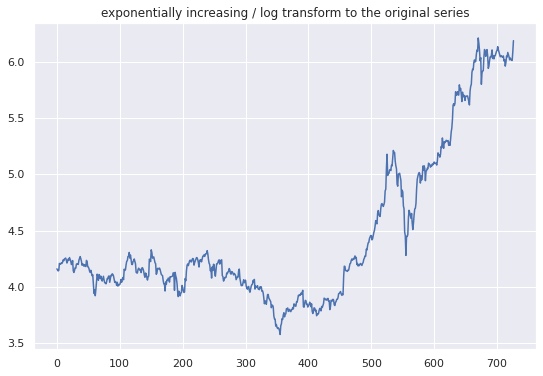

In [14]:
stock['Natural Log'] = stock['Close'].apply(lambda x: np.log(x))
plt.title('exponentially increasing / log transform to the original series')
stock['Natural Log'].plot(figsize=(9,6));

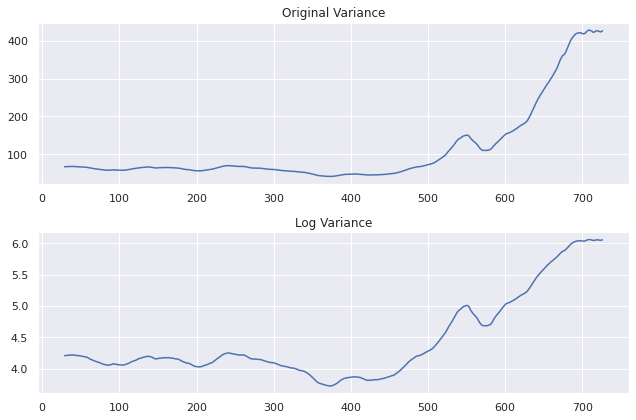

In [16]:
stock['Original Variance'] = stock['Close'].rolling(30).mean()
stock['Log Variance'] = stock['Natural Log'].rolling(30).mean()

fig, ax = plt.subplots(2, 1, figsize=(9,6))
stock['Original Variance'].plot(ax=ax[0], title='Original Variance')
stock['Log Variance'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout();

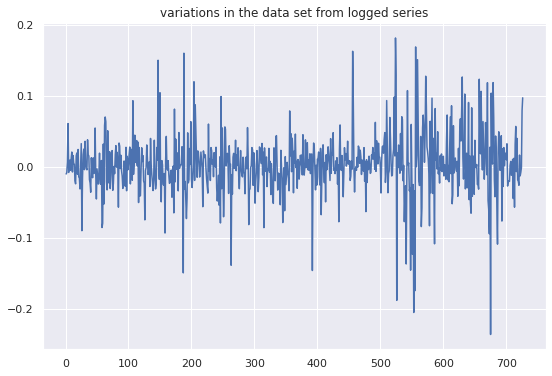

In [17]:
stock['Logged First Difference'] = stock['Natural Log'] - stock['Natural Log'].shift()
plt.title('variations in the data set from logged series')
stock['Logged First Difference'].plot(figsize=(9,6));

Notice how tightly packed the mass is around 0. It also appears to be pretty evenly distributed - the marginal distributions on both axes are roughly normal. This seems to indicate that knowing the index value one day doesnt tell us much about what it will do the next day. It probably comes as no surprise that theres very little correlation between the change in value from one day to the next. Although I didnt plot them out here, the other lagged variables that we created above show similar results. There could be a relationship to other lag steps that we havent tried, but its impractical to test every possible lag value manually. Fortunatelythere is a class of functions that can systematically do this for us.

seasonal" effects


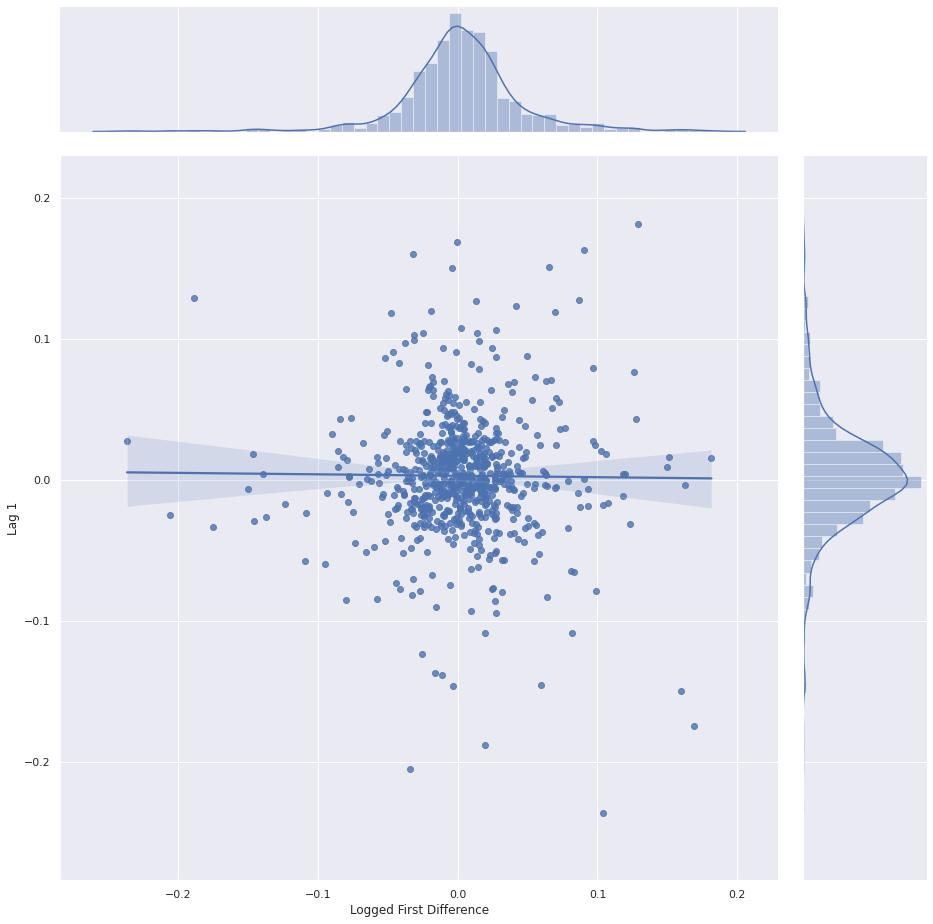

In [19]:
stock['Lag 1'] = stock['Logged First Difference'].shift()
stock['Lag 2'] = stock['Logged First Difference'].shift(2)
stock['Lag 5'] = stock['Logged First Difference'].shift(5)
stock['Lag 30'] = stock['Logged First Difference'].shift(30)

sns.jointplot(
    'Logged First Difference', 'Lag 1', 
    stock, kind='reg', height=13)


print('Notice how tightly packed the mass is around 0. It also appears to \
be pretty evenly distributed - the marginal distributions on both axes are \
roughly normal. This seems to indicate that knowing the index value one day \
doesnt tell us much about what it will do the next day. It probably comes as \
no surprise that theres very little correlation between the change in value \
from one day to the next. Although I didnt plot them out here, the other \
lagged variables that we created above show similar results. \
There could be a relationship to other lag steps that we havent tried, \
but its impractical to test every possible lag value manually. Fortunately\
there is a class of functions that can systematically do this for us.')
print('\nseasonal" effects')

computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps.


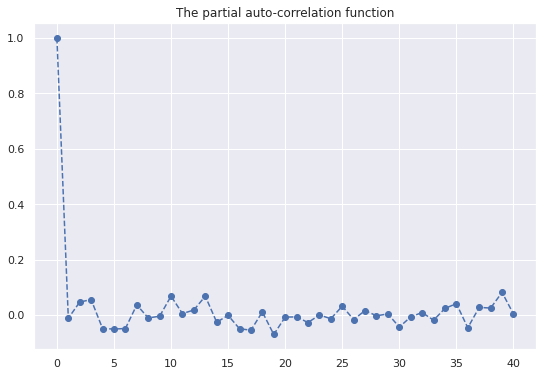

In [20]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(
    stock['Logged First Difference'].iloc[1:])
lag_partial_correlations = pacf(stock['Logged First Difference'].iloc[1:])



#####  The partial auto-correlation function 
fig, ax = plt.subplots(figsize=(9,6))

ax.set_title('The partial auto-correlation function')
ax.plot(lag_correlations, marker='o', linestyle='--')
print('computes the correlation at each lag step that is NOT \
already explained by previous, lower-order lag steps.')

The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above). What this shows is that there is no significant (> 0.2) correlation betweenthe value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk. Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodelscomes with a decompose function out of the box.
Since we dont see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal patternthough it can be very useful. The folling instance, for example, is a samplefrom the statsmodels documentation showing CO2 emissions data over time.


<Figure size 900x600 with 0 Axes>

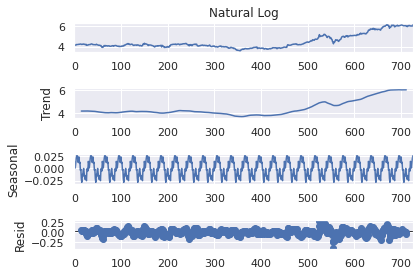

In [29]:
print('The auto-correlation and partial-autocorrelation results are very \
close to each other (I only plotted the auto-correlation results above). \
What this shows is that there is no significant (> 0.2) correlation between\
the value at time t and at any time prior to t up to 40 steps behind. \
In order words, the series is a random walk. Another interesting technique \
we can try is a decomposition. This is a technique that attempts to break \
down a time series into trend, seasonal, and residual factors. Statsmodels\
comes with a decompose function out of the box.')


from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    stock['Natural Log'], model='additive', freq=30)

fig = plt.figure(figsize = (9,6), dpi = 100)
fig = decomposition.plot()

print('Since we dont see any real cycle in the data, the visualization is not that \
effective in this case. For data where this is a strong seasonal pattern\
though it can be very useful. The folling instance, for example, is a sample\
from the statsmodels documentation showing CO2 emissions data over time.')

<Figure size 432x288 with 0 Axes>

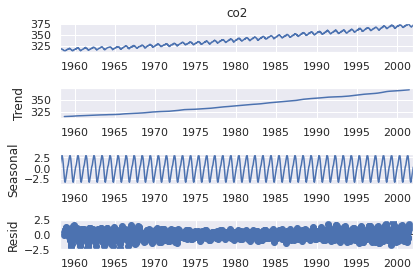

In [34]:
co2_data = sm.datasets.co2.load_pandas().data
co2_data.co2.interpolate(inplace=True)
result = sm.tsa.seasonal_decompose(co2_data.co2)
fig = plt.figure();
fig = result.plot();

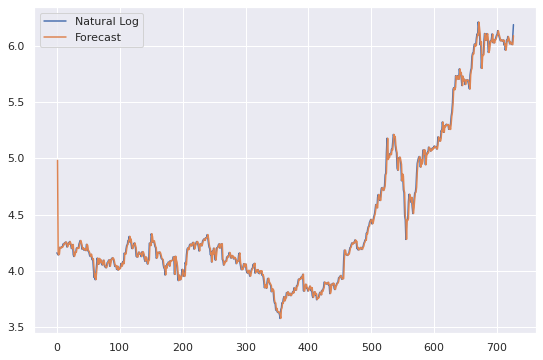

In [37]:
model = sm.tsa.ARIMA(stock['Natural Log'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
stock['Forecast'] = results.fittedvalues
stock[['Natural Log', 'Forecast']].plot(figsize=(9,6));

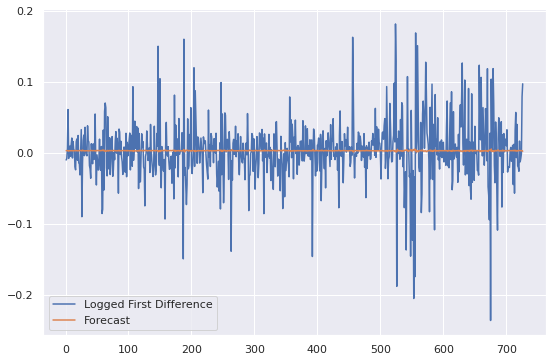

In [39]:
model = sm.tsa.ARIMA(
    stock['Logged First Difference'].iloc[1:], order=(1, 0, 0))

results = model.fit(disp=-1)
stock['Forecast'] = results.fittedvalues
stock[['Logged First Difference', 'Forecast']].plot(figsize=(9,6));

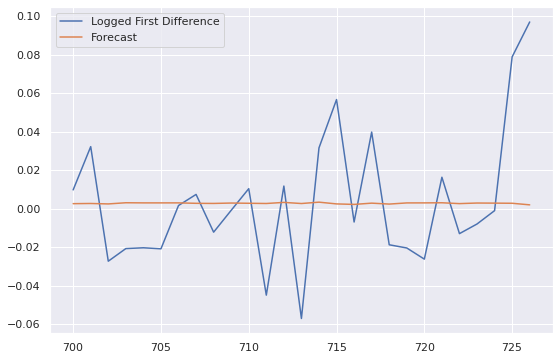

In [41]:
stock[
    ['Logged First Difference',
    'Forecast']].iloc[700:1000, :].plot(figsize=(9,6));

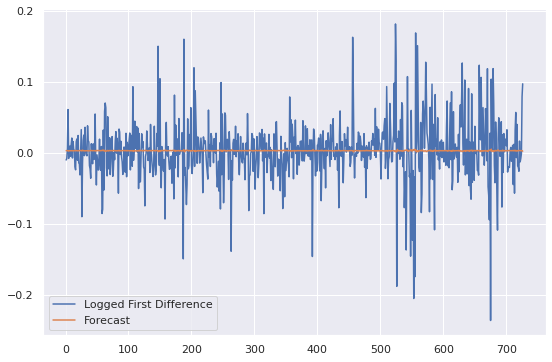

In [42]:
model = sm.tsa.ARIMA(stock['Logged First Difference'].iloc[1:],
                     order=(0, 0, 1))

results = model.fit(disp=-1)
stock['Forecast'] = results.fittedvalues
stock[['Logged First Difference', 'Forecast']].plot(figsize=(9,6));

# Asset_Beta_AND_Mkt_Beta (CapM)

In [44]:
from patsy import dmatrices

# DISPLAY AS PERCENTAGE
def display_as_percentage(val):
    return ('{:.4f} %'.format(val * 100))

yf.pdr_override()

# ticker = input('Ticker: ')
# ticker = 'GOOGL'
df1 = pdr.get_data_yahoo(ticker, start, end)
df2 = pdr.get_data_yahoo(tickers[1], start, end)

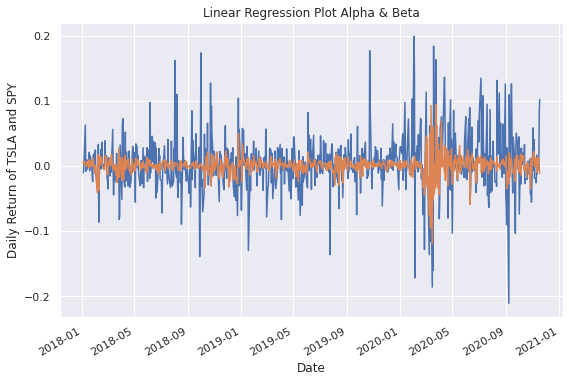

In [47]:
return1 = df1.Close.pct_change()[1:]
return2 = df2.Close.pct_change()[1:]

plt.figure(figsize=(9,6))
return1.plot()
return2.plot()
plt.ylabel('Daily Return of '+str(ticker)+' and SPY')
plt.title('Linear Regression Plot Alpha & Beta');

In [52]:
from statsmodels import regression

X = return1.values
Y = return2.values

def linreg(x,y):
    x=sm.add_constant(x)
    model=regression.linear_model.OLS(y,x).fit()
    x=x[:,1]                                      
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print(f'\nAlpha = {display_as_percentage(alpha)} \nBeta = {display_as_percentage(beta)}\n')


Alpha = -0.0064 % 
Beta = 15.1214 %



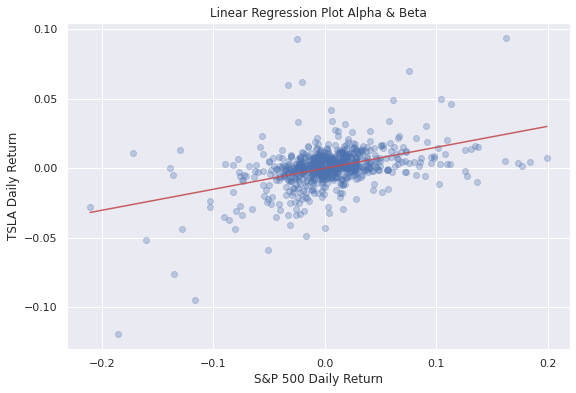

In [53]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.figure(figsize=(9,6))

plt.scatter(X, Y, alpha=0.3)                         
plt.xlabel('S&P 500 Daily Return')
plt.ylabel(f'{ticker} Daily Return')
plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.title('Linear Regression Plot Alpha & Beta');

#### Capital Asset Pricing Model or CAPM (How to Calculate Beta)
* One of the most common ways to calculate beta is using the Capital Asset Pricing Model or CAPM. - Have a look at the CAPM model:E (Ra) = Rf + Ba [ E (Rm) - Rf]
* CAPM model states that the expected return of an asset ‘E (Ra)’ is equal to the risk-free return in the market plus the difference between the expected return of the market and risk-free rate ‘[E (Rm) - Rf]’ multiplied by the asset’s beta ‘Ba’.

* If we have all the values except the asset’s beta, we can calculate the beta using:

* Ba = [E (Ra) - Rf] / [ E (Rm) - Rf]
* We can even find beta by performing the ‘regression analysis’.

* When one tries to capture a mathematical relationship between ‘x’ and ‘y’ variables, by fitting a line, polynomial or a curve through scatter plots, such that one can make a reasonably good prediction of ‘y’ given ‘x’, then the mathematical process of deriving such an equation between x and y is called the regression analysis.This equation can also arrived at by using a machine learning based regression model.

* If we try to fit a ‘line’ through this scatter plot that “best” explains the observed values of ‘y’ in terms of observed values of ‘x’, we get a simple linear regression model.

* Linear regression assumes a linear relationship between the dependent and independent variables.

* The following regression equation describes that relation:

* Yi = b0 + b1 Xi + ei

* We refer to the intercept ‘b0’ and slope coefficient ‘b1’ as the regression coefficients and ei as the random error.

* Rasset = ex-post alpha + beta of asset * Rbenchmark + eiTo understand the coefficients more intuitively, if we consider the returns for Google vs. S&P 500 index, then the slope coefficient in a regression line is called the stock’s beta, as it measures the relative amount of systematic or undiversifiable risk in Google’s returns. * If the slope of Google returns is more than 1, its returns tend to increase or decrease more than the market returns. A slope or beta of 1 would have the same level of systematic risk as that of the market on an average, and a slope or beta less than 1 implies that the returns increase or decrease by less than the change in the market returns. The intercept term is the ex-post alpha i.e. the measure of excess returns of Google as compared to market index returns. If the intercept term is negative, it means Google has underperformed S&P on a risk adjusted basis and a positive intercept means it has had excess returns on risk adjusted basis. All the points on the regression equation line, predict the ‘y’ values for the corresponding ‘x’ values. However, the optimal regression line is the one for which the sum of the squared differences (vertical distances) or the sum of squared errors or SSE between the ‘y’ values predicted by the regression equation/line and the actual ‘y’ values is minimal. Thus, the regression line minimizes the SSE. This is the reason why simple linear regression is also called as Ordinary Least Squares or OLS, and the estimated (predicted) values by the regression equation i.e. y predicted are called least squares estimates. The slope coefficient ‘b1’ of the regression line is calculated as the covariance of x and y divided by the variance of x (covxy /σ2x ), and the intercept coefficient is the line's intersection with the y axis at x = 0.